In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import GPy
from IPython.display import display
import three_desc_model as exponential_new
from cutoffs import Polynomial
GPy.plotting.change_plotting_library('matplotlib')

In [2]:
dataset_full = pd.read_csv('all_dataset.csv', index_col=0)
symbol="Siemens"
k=0
count=0
dataset_full["IDnum"]=pd.Series()
for i in range(len(dataset_full)):
    dataset_full.at[i,"IDnum"]=k
    count = count +1
    if (count==dataset_full["Num_tot_turb"].iloc[i]):
        k=k+1
        count=0
dataset_full["Num_tot_turb"]=dataset_full["Num_tot_turb"].astype(int)
dataset_full["Turb_num"]=dataset_full["Turb_num"].astype(int)
dataset_full["IDnum"]=dataset_full["IDnum"].astype(int)
numsims=dataset_full["IDnum"].iloc[-1]+1
turb = [symbol]


In [3]:
dataset_full

,X_coord,Y_coord,Ref_wind,Num_tot_turb,ID,Turb_num,IDnum
0,0.000000,0.000000,7.479762,2,2_turbine_240_degrees_279.0_meters,0,0
1,241.621088,139.500000,7.576231,2,2_turbine_240_degrees_279.0_meters,1,0
2,0.000000,0.000000,7.473602,2,2_turbine_241_degrees_279.0_meters,0,1
3,244.018898,135.261884,7.567527,2,2_turbine_241_degrees_279.0_meters,1,1
4,0.000000,0.000000,7.467848,2,2_turbine_242_degrees_279.0_meters,0,2
...,...,...,...,...,...,...,...
1779,3164.356744,-110.000000,6.978195,3,3_turbine_358th_simulation,1,710
1780,499.388946,-80.000000,6.763982,3,3_turbine_358th_simulation,2,710
1781,0.000000,0.000000,7.306684,3,3_turbine_359th_simulation,0,711
1782,2630.260284,143.000000,7.232828,3,3_turbine_359th_simulation,1,711


In [4]:
nl=exponential_new.NeighborlistCalculator(cutoff=4001,cone_grad=0.12582561117875557, cone_offset=72.24947126849844)
Gs = {"Siemens": [{"type":"G2", "turbine":"Siemens","eta":4.25387599, "offset": 1.0151402},
                  {"type":"G4", "elements":"Siemens","eta":2.56450515, "gamma":8.04475192, "zeta": 2.5356155},
                  {"type":"G6", "elements":"Siemens","eta":2.33043463, "gamma": 0.50753377, "zeta": 0.93372721},
                  
                 ]}
finpr=exponential_new.FingerprintCalculator(cutoff=4001,Gs=Gs,Rct=3000,delta_R=100,cone_grad=0.12582561117875557, cone_offset=72.24947126849844)
count=0
dataset_fp=np.empty(shape=(0, 3))
dataset_ws=np.empty(shape=(0, 1))
dataset_pos=np.empty(shape=(0, 2))
for i in range(numsims):
    numturb=dataset_full["Num_tot_turb"].iloc[count]
    position = np.empty((numturb,2))
    ws = np.empty((numturb,1))
    fp = np.empty((numturb,3))
    for k in range(numturb):
        position[k,0]=dataset_full.at[count,"X_coord"]
        position[k,1]=dataset_full.at[count,"Y_coord"]
        ws[k,0]=dataset_full.at[count,"Ref_wind"]
        count = count+ 1
    neigh=nl.calculate(turb*numturb,position)
    fingerprints=finpr.calculate(turb*numturb,position,neigh,symbol)
    fingerprints=np.array(fingerprints)
    dataset_fp=np.append(dataset_fp,fingerprints,axis=0)
    dataset_ws=np.append(dataset_ws,ws,axis=0)
    dataset_pos=np.append(dataset_pos,position,axis=0)
dataset=np.concatenate((dataset_fp, dataset_ws),axis=1)
dataset = pd.DataFrame(dataset, columns = ['Fingerprint(G2)','Fingerprint(G4)','Fingerprint(G6)','Ref_Wind_Speed'])
X=dataset[["Fingerprint(G2)","Fingerprint(G4)","Fingerprint(G6)"]].to_numpy()
Y=dataset[["Ref_Wind_Speed"]].to_numpy()
train_dataset = dataset.sample(frac=0.8, random_state=0)
test_dataset = dataset.drop(train_dataset.index)
Xtrain=train_dataset[["Fingerprint(G2)","Fingerprint(G4)","Fingerprint(G6)"]].to_numpy()
Ytrain=train_dataset[["Ref_Wind_Speed"]].to_numpy()
Xtest=test_dataset[["Fingerprint(G2)","Fingerprint(G4)","Fingerprint(G6)"]].to_numpy()
Ytest=test_dataset[["Ref_Wind_Speed"]].to_numpy()

In [5]:
dataset

,Fingerprint(G2),Fingerprint(G4),Fingerprint(G6),Ref_Wind_Speed
0,1.000000,0.344932,1.047008,7.479762
1,1.000000,0.344932,1.047008,7.576231
2,1.000000,0.344932,1.047008,7.473602
3,1.000000,0.344932,1.047008,7.567527
4,1.000000,0.344932,1.047008,7.467848
...,...,...,...,...
1779,0.908724,0.207061,0.807403,6.978195
1780,0.491518,0.264709,1.047008,6.763982
1781,1.000000,0.344932,1.047008,7.306684
1782,0.846665,0.226261,0.691196,7.232828


In [6]:
# define kernel
ker = GPy.kern.RBF(3,lengthscale=0.1)# + GPy.kern.White(2)

In [7]:
# create simple GP model
m = GPy.models.GPRegression(Xtrain,Ytrain,ker)

In [8]:
# optimize and plot
m.optimize(messages=True,max_f_eval = 1000)
#fig = m.plot()
#display(GPy.plotting.show(fig, filename='basic_gp_regression_notebook_2d'))
display(m)

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s00  0000   1.657382e+03           nan 
    02s01  0006  -1.030441e+03   2.595432e+04 
    04s53  0014  -1.390592e+03   2.204930e+03 
    08s31  0026  -1.414841e+03   2.068019e+01 
    09s53  0030  -1.414877e+03   1.258577e-04 
    10s11  0032  -1.414877e+03   5.885184e-07 
Runtime:     10s11
Optimization status: Converged



GP_regression.,value,constraints,priors
rbf.variance,30.80089397639583,+ve,
rbf.lengthscale,0.3119482562041911,+ve,
Gaussian_noise.variance,0.006584781669025141,+ve,


In [9]:
print(m)


Name : GP regression
Objective : -1414.8770853952997
Number of Parameters : 3
Number of Optimization Parameters : 3
Updates : True
Parameters:
  GP_regression.           |                 value  |  constraints  |  priors
  rbf.variance             |     30.80089397639583  |      +ve      |        
  rbf.lengthscale          |    0.3119482562041911  |      +ve      |        
  Gaussian_noise.variance  |  0.006584781669025141  |      +ve      |        


 c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\GPy\plotting\matplot_dep\plot_definitions.py:323: UserWarning:The following kwargs were not used by contour: 'label', 'linewidth'


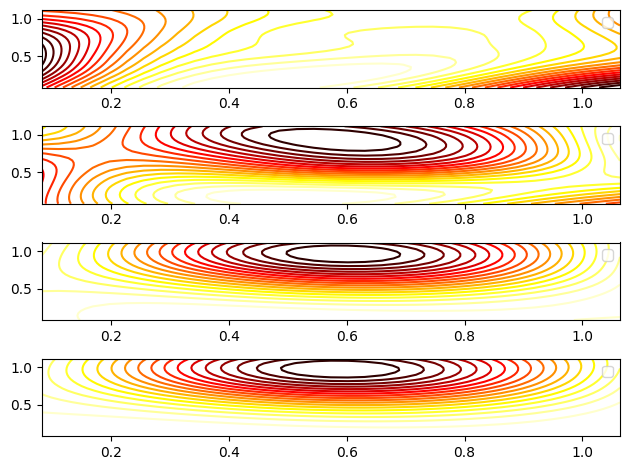

In [10]:
slices = [0.2, 0.5, 0.8, 1.0]
figure = GPy.plotting.plotting_library().figure(4, 1)
                            
for i, y in zip(range(4), slices):
    canvas = m.plot(figure=figure, fixed_inputs=[(1,y)], row=(i+1), plot_data=False)
#GPy.plotting.show(canvas, filename='basic_gp_regression_notebook_slicing')

In [11]:
[Ypred,Yvar]=m.predict(Xtest)
error_test=np.abs(Ypred-Ytest)
np.max(error_test)

0.35163376008627534

In [12]:
[Yval,Yvalvar]=m.predict(Xtrain)
error_train=np.abs(Yval-Ytrain)
np.max(error_train)

0.3446756665716366

In [13]:
[Yall,Yallvar]=m.predict(X)
error_all=np.abs(Yall-Y)
np.max(error_all)

0.35163376008627534

In [14]:
#make predictions
position=np.array([[   0.   ,  0.        ],[ 794.36576595 ,  43.85822902], [ 449.31175435,  178.73675336], [2031.48005906 ,  71.47280391]])
neigh=nl.calculate(turb*4,position)
fingerprints=np.array(finpr.calculate(turb*4,position,neigh,symbol))
refwind,refstdev=m.predict(fingerprints)
print(neigh)
print(fingerprints)
print(refwind)
print(refstdev)

[[], [0], [], [0, 1, 2]]
[[1.         0.34493215 1.04700824]
 [0.57034779 0.14494835 1.04700824]
 [1.         0.34493215 1.04700824]
 [0.52706604 0.04468339 0.0772671 ]]
[[7.39822176]
 [6.20027228]
 [7.39822176]
 [4.99785094]]
[[0.00659174]
 [0.00694498]
 [0.00659174]
 [1.24979843]]


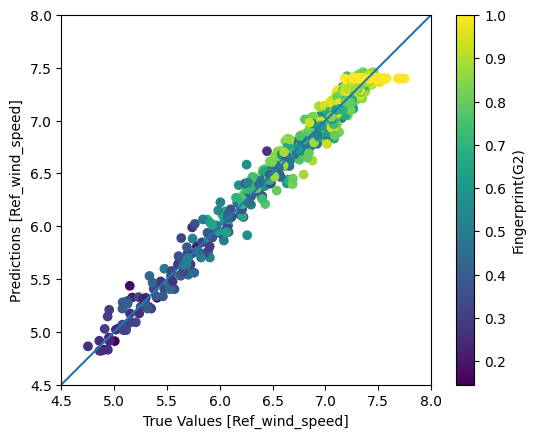

In [15]:
a = plt.axes(aspect='equal')
plt.scatter(Ytest, Ypred,c=Xtest[:,0])     #"Fingerprint(G2)"
plt.scatter(Ytrain, Yval,c=Xtrain[:,0])  #"Fingerprint(G2)"
plt.xlabel('True Values [Ref_wind_speed]')
plt.ylabel('Predictions [Ref_wind_speed]')
cbar=plt.colorbar()
cbar.set_label('Fingerprint(G2)')
lims = [4.5, 8]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

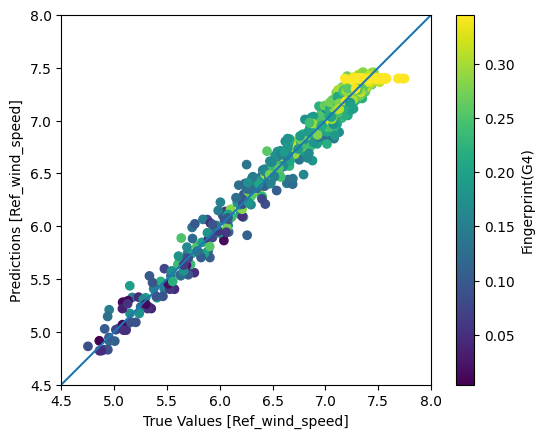

In [16]:
a = plt.axes(aspect='equal')
plt.scatter(Ytest, Ypred,c=Xtest[:,1])     #"Fingerprint(G4)"
plt.scatter(Ytrain, Yval,c=Xtrain[:,1])  #"Fingerprint(G4)"
plt.xlabel('True Values [Ref_wind_speed]')
plt.ylabel('Predictions [Ref_wind_speed]')
cbar=plt.colorbar()
cbar.set_label('Fingerprint(G4)')
lims = [4.5, 8]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

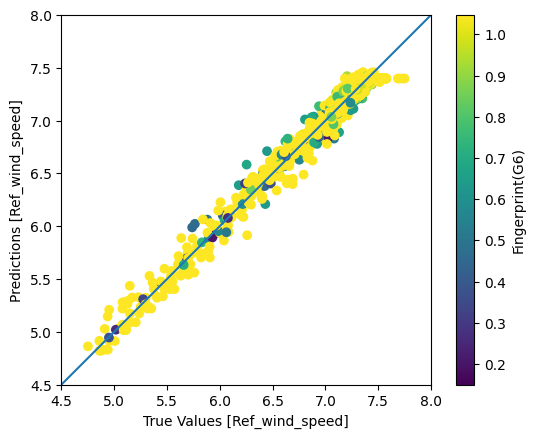

In [17]:
a = plt.axes(aspect='equal')
plt.scatter(Ytest, Ypred,c=Xtest[:,2])     #"Fingerprint(G6)"
plt.scatter(Ytrain, Yval,c=Xtrain[:,2])  #"Fingerprint(G6)"
plt.xlabel('True Values [Ref_wind_speed]')
plt.ylabel('Predictions [Ref_wind_speed]')
cbar=plt.colorbar()
cbar.set_label('Fingerprint(G6)')
lims = [4.5, 8]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

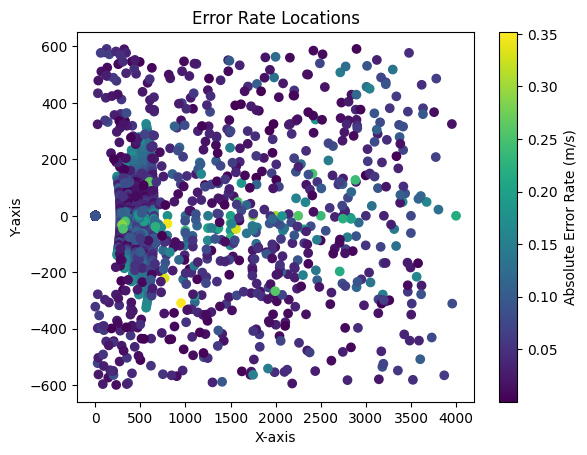

In [18]:
plt.scatter(dataset_pos[:,0], dataset_pos[:,1],c=error_all)
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title('Error Rate Locations')
cbar=plt.colorbar()
cbar.set_label('Absolute Error Rate (m/s)')

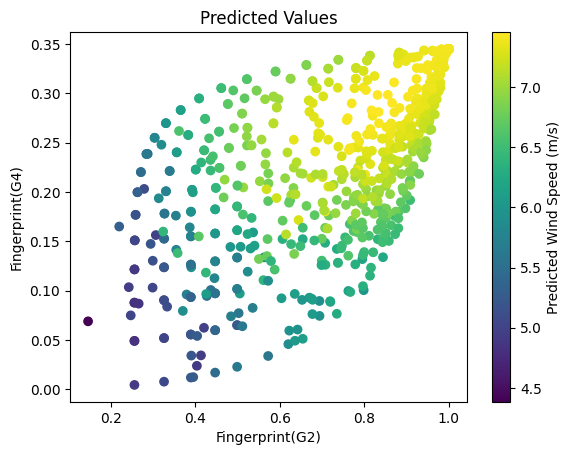

In [19]:
a = plt.axes
plt.scatter(Xtest[:,0], Xtest[:,1],c=np.abs(Ypred))
plt.scatter(Xtrain[:,0], Xtrain[:,1],c=np.abs(Yval))
#plt.scatter(train_labels, train_predictions)
plt.xlabel('Fingerprint(G2)')
plt.ylabel('Fingerprint(G4)')
plt.title('Predicted Values')
cbar=plt.colorbar()
cbar.set_label('Predicted Wind Speed (m/s)')

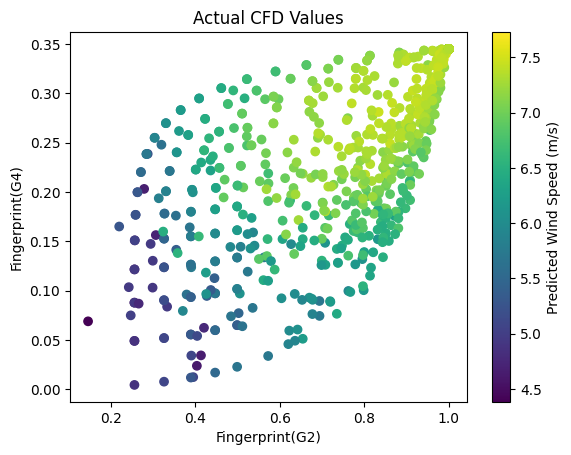

In [20]:
a = plt.axes
plt.scatter(Xtest[:,0], Xtest[:,1],c=np.abs(Ytest))
plt.scatter(Xtrain[:,0], Xtrain[:,1],c=np.abs(Ytrain))
#plt.scatter(train_labels, train_predictions)
plt.xlabel('Fingerprint(G2)')
plt.ylabel('Fingerprint(G4)')
plt.title('Actual CFD Values')
cbar=plt.colorbar()
cbar.set_label('Predicted Wind Speed (m/s)')

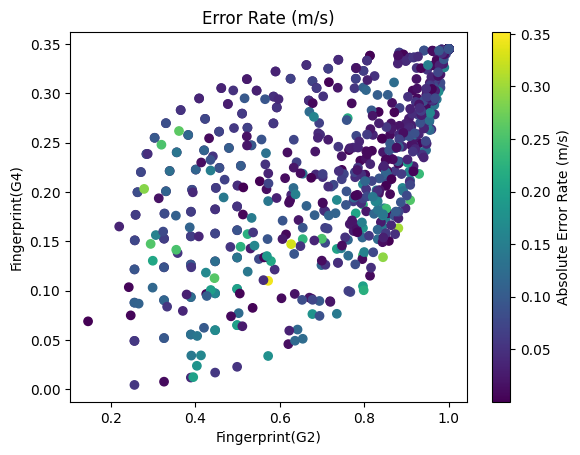

In [21]:
a = plt.axes
plt.scatter(X[:,0], X[:,1],c=error_all)
#plt.scatter(Xtrain[:,0], Xtrain[:,1],c=np.abs(Ytrain))
#plt.scatter(train_labels, train_predictions)
plt.xlabel('Fingerprint(G2)')
plt.ylabel('Fingerprint(G4)')
plt.title('Error Rate (m/s)')
cbar=plt.colorbar()
cbar.set_label('Absolute Error Rate (m/s)')

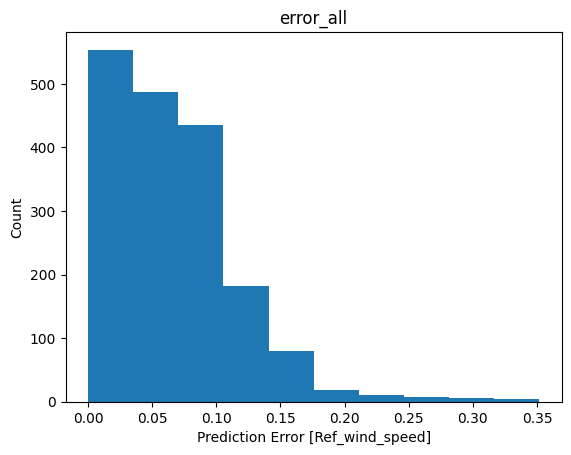

In [22]:
plt.hist(error_all, bins=10)
plt.xlabel('Prediction Error [Ref_wind_speed]')
plt.title('error_all')
_ = plt.ylabel('Count')

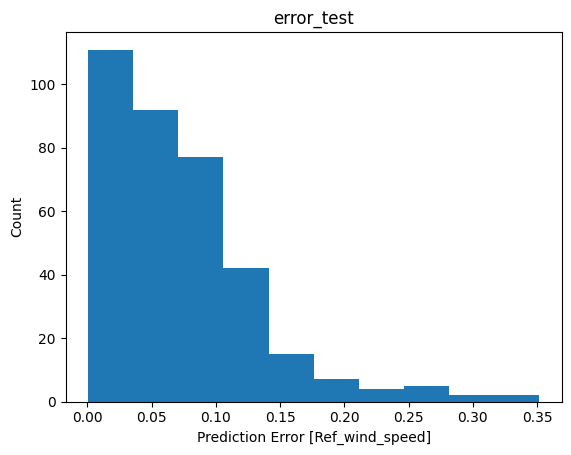

In [23]:
plt.hist(error_test, bins=10)
plt.xlabel('Prediction Error [Ref_wind_speed]')
plt.title('error_test')
_ = plt.ylabel('Count')

In [24]:
import numpy
from mayavi.mlab import *

def test_points3d():


    x = X[:,0] #Fingerprint(G2)
    y = X[:,1] #Fingerprint(G4)
    z = X[:,2] #Fingerprint(G6)
    s = error_all.flatten()
    colorbar(orientation='vertical')
    xlabel('Fingerprint(G2)')
    ylabel('Fingerprint(G4)')
    zlabel('Fingerprint(G6)')
    return points3d(x, y, z, s, colormap="blue-red", scale_factor=0.1)
test_points3d()
#colorbar(object=all_labels, title="Points in Mayavi")
#view()
show()

ModuleNotFoundError: No module named 'mayavi'